# BEST MODEL
Paste parameters and workflow of best model here

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [6]:
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')
# read in pickled features
total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']
# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month
# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

## Train-Validation-Test Split
Because this is time-series data and the features set is dependent on the past, the train test split is very delicate. The validation and test feature set will actually draw from data in the past (rolling mean, std, etc.). Therefore, when creating the model, the entire dataset must be used. But I must be careful not to train the model on data from the 'future'.

### San Juan

In [7]:
# get monthly trend of whole test df
lr_sj_month = LinearRegression()
X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

lr_sj_month.fit(X_months, y)
lr_sj_predictions = lr_sj_month.predict(X_months)
monthly_trend = pd.Series(lr_sj_predictions).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend  #actual is reduced by the values taken


# create test df of rolling weather stats
# rolling means df
# selecting features
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:936]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[60:936]


# combine all dfs
# check and include to features
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[936:]
Xtest_means2 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_sj_resid = LinearRegression()
lr_sj_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [4]:
# make predictions on monthly data and residual data
lr_sj_monthly_predictions = lr_sj_month.predict(Xtest_months)  # model trained x_months and cases_sj
sj_monthly_preds = pd.Series(lr_sj_monthly_predictions).rolling(3, min_periods=1).mean()
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))

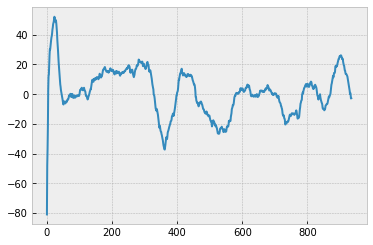

In [8]:
Xtest_means1_for_train_data = df_sj['station_avg_temp_c'].rolling(window = 52, min_periods=1).mean()[:936]
Xtest_weather = pd.concat([Xtest_means1_for_train_data], axis = 1)
residual_predictions_for_train_data = lr_sj_resid.predict(Xtest_weather)

residual_predictions_for_train_data_plot = pd.Series(residual_predictions_for_train_data).rolling(1, min_periods=1).mean()
plt.plot(residual_predictions_for_train_data_plot)
# plt.plot(y)

### Iquitos

In [5]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[60:520]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[520:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)

# fit on model
lr_iq_resid = LinearRegression()
lr_iq_resid.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

In [7]:
total_preds_linear_regression = list(sj_cases_pred) + list(iq_cases_pred)

In [113]:
from sklearn.ensemble import RandomForestRegressor
rf_monthly_sj = RandomForestRegressor(n_estimators=1000, max_features='auto',
                                 max_depth=10, min_samples_leaf=0.005,
                                 criterion='mae', min_weight_fraction_leaf=0.1
                                , warm_start=True)

X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

rf_monthly_sj.fit(X_months,y)

rf_sj_predictions = rf_monthly_sj.predict(X_months)
monthly_trend = pd.Series(rf_sj_predictions).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend  #actual is reduced by the values taken

# create test df of rolling weather stats
# rolling means df
# selecting features
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[60:936]
Xtrain_means2 = df_sj['precipitation_amt_mm'].rolling(window = 53).mean()[60:936]
Xtrain_means3 = df_sj['ndvi_se'].rolling(window = 25).mean()[60:936]

# combine all dfs
# check and include to features
Xtrain = pd.concat([Xtrain_means1, Xtrain_means2, Xtrain_means3], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[936:]
Xtest_means2 = df_sj['precipitation_amt_mm'].rolling(window = 53).mean()[936:]
Xtest_means3 = df_sj['ndvi_se'].rolling(window = 25).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1, Xtest_means2, Xtest_means3], axis = 1)

# fit on model
rf_sj_resid = RandomForestRegressor(n_estimators=1000, max_features='auto',
                                 max_depth=10, min_samples_leaf=0.005,
                                 criterion='mae', min_weight_fraction_leaf=0.1
                                , warm_start=True)
# train the model using selected features
rf_sj_resid.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.005, min_samples_split=2,
           min_weight_fraction_leaf=0.1, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [119]:
# plt.plot(y)
# plt.plot(monthly_trend)
# mean_absolute_error(y, monthly_trend)

In [115]:
# make predictions on monthly data and residual data
rf_sj_monthly_predictions = rf_monthly_sj.predict(Xtest_months)  # model trained x_months and cases_sj
sj_monthly_preds = pd.Series(rf_sj_monthly_predictions).rolling(3, min_periods=1).mean()
sj_resid_preds = rf_sj_resid.predict(Xtest_weather)
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))

In [ ]:
plt.plot(y)
plt.plot(monthly_trend)

In [116]:
rf_monthly_iq = RandomForestRegressor(n_estimators=1000, max_features='auto',
                                 max_depth=10, min_samples_leaf=0.005,
                                 criterion='mae', min_weight_fraction_leaf=0.1
                                , warm_start=True)

X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

rf_monthly_iq.fit(X_months, y)
monthly_trend = pd.Series(rf_monthly_iq.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:520]
Xtrain_means2 = df_iq['precipitation_amt_mm'].rolling(window = 5).mean()[60:520]
# combine all dfs
Xtrain = pd.concat([Xtrain_means1, Xtrain_means2], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[520:]
Xtest_means2 = df_iq['precipitation_amt_mm'].rolling(window = 5).mean()[520:]
# combine all dfs
Xtest_weather = pd.concat([Xtest_means1, Xtest_means2], axis = 1)

# fit on model
rf_iq_resid = RandomForestRegressor(n_estimators=1000, max_features='auto',
                                 max_depth=10, min_samples_leaf=0.005,
                                 criterion='mae', min_weight_fraction_leaf=0.1
                                , warm_start=True)
rf_iq_resid.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.005, min_samples_split=2,
           min_weight_fraction_leaf=0.1, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [117]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(rf_monthly_iq.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = rf_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

In [118]:
total_preds_random_forest = list(sj_cases_pred) + list(iq_cases_pred)
error = mean_absolute_error(total_preds_linear_regression, total_preds_random_forest)
error

12.651442307692308

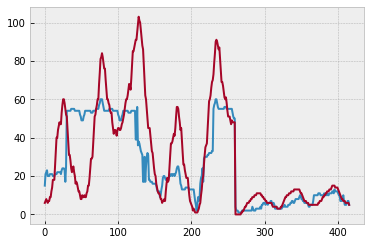

In [91]:
plt.plot(total_preds_random_forest)
plt.plot(total_preds_linear_regression)


In [84]:
### Make CSV

In [8]:
# submission
submission_format = pd.read_csv('./datasets/submission_format.csv')

In [9]:
submission_format['total_cases'] = total_preds_linear_regression
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

In [10]:
# Save to CSV, use current date
submission_format.to_csv('submissions/dengue_submission_21_07_18v2.csv', index=False)

In [11]:
submission_format.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,7
2,sj,2008,20,6
3,sj,2008,21,5
4,sj,2008,22,5


In [32]:
predictions_for_sj = submission_format[submission_format['city']=='sj']

special_week_data_sj = predictions_for_sj[(predictions_for_sj['weekofyear'] >= 35) & (predictions_for_sj['weekofyear'] <= 45)]
special_week_data['total_cases'] = special_week_data['total_cases'] + 10
predictions_for_sj.loc[special_week_data_sj.index, 'total_cases'] =special_week_data['total_cases']

/home/eranga/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/eranga/.local/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
predictions_for_iq = submission_format[submission_format['city']=='iq']

special_week_data_iq = predictions_for_iq[(predictions_for_iq['weekofyear'] >= 45) & (predictions_for_iq['weekofyear'] <= 50)]

special_week_data_iq['total_cases'] = special_week_data_iq['total_cases'] + 10

predictions_for_iq.loc[special_week_data_iq.index, 'total_cases'] =special_week_data_iq['total_cases']

/home/eranga/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/eranga/.local/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
final_submit = pd.concat([predictions_for_sj,predictions_for_iq])


In [51]:
final_submit.to_csv('submissions/dengue_submission_19_07_18v2.csv', index=False)

### Submitted MAEs!!!!
* monthly trend and mean `station_avg_temp_c` with window = 52 was 20.7764
* monthly trend and mean `station_avg_temp_c` with window = 52 and std window = 8 was 20.7981
* monthly trend and mean `station_avg_temp_c` and `precipitation_amt_mm` with window = 52 and std window = 8 was 24.1274
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and iq used 'ndvi_nw' with window = 68 was 23.5697
* monthly trend and sj used mean `station_avg_temp_c` with window = 55 and `ndvi_se` with window = 10 and iq used 'ndvi_nw' with window = 68 was 21.337
* Next steps: use other rolling features (and std? and shifted? and exponentially weighted mean?)